## Foreword

In this Jupyter Notebook, I'll use our notes from class to model the elastic scattering of two Ar atoms. The interaction between the two argon atoms shall be modeled by a Morse potential. For both shallow and deep potentials (smaller and larger values of $D_{e}$, respectively), I'll show and comment on the following:

- Plots of $A_{l}$, $B_{l}$, and $\delta_{l}$ as a function of $l$ at constant $E$
- Plots of $A_{l}$, $B_{l}$, and $\delta_{l}$ as a function of $E$ at constant $l$

## Function Definitions

First, I'll import required packages/modules that will be used throughout my calculations.

In [1]:
import math
import cmath
import numpy as np
from scipy.special import jv, yv, hankel1, hankel2
import matplotlib.pyplot as plt

from pycav.quantum import numerov as numerov_imported

The function below calculates the Morse potential as a function of $r$, the separation of the atoms. Later, I'll visualize this for both the shallow and deep well cases.

In [2]:
def morse_potential(r):
    return De * (np.exp(-2 * alpha * (r - re)) - 2 * np.exp(-alpha * (r - re)))

The Numerov method is carried out using the function in the following code cell. As we outlined in class, using Bessel functions rather than exponential functions in our formulation of this problem allows us to use Numerov on a smaller scale than would be otherwise required. For any case that Numerov is used in this notebook, it will be done on a grid that extends from $r=5.5$ to $r=17.5$, with a stepsize of $h=0.002$. As will be seen later, this appears sufficient to visualize the trends we expect of this problem.

In [3]:
def Numerov(h, k_squared_n_plus_1, U_n, k_squared_n, U_n_minus_1, k_squared_n_minus_1):
    num = ((2 - (10 * h ** 2 * k_squared_n) / 12) * U_n) - ((1 + (h ** 2 * k_squared_n_minus_1) / 12) * U_n_minus_1)
    denom = (1 + (h ** 2 * k_squared_n_plus_1) / 12)
    return num / denom

The next function is the main component of this assignment. Given an energy, $E$, a grid upon which to perform Numerov, and a value of $l$, it calculates $A_{l}$, $B_{l}$, and $\delta_{l}$.

In [4]:
def calculate_delta(E, potential, r_0, r_n, h, l):
    
    rs = np.arange(r_0, r_n + h, h)
    Vs = potential(rs)
    
    k = ((2 * mu * E) ** 0.5) / h_bar
    k_squared = (2 * mu * (E - Vs)) / (h_bar ** 2)
    xs = rs * k
    kappa = ((2 * mu * abs(Vs[0] - E)) / (h_bar ** 2)) ** 0.5
    
    if potential.__name__ == "morse_potential":
        U_n_minus_1 = 1e-10
        U_n = (1 + kappa * h) * U_n_minus_1
        all_Us = [U_n_minus_1, U_n]
    
        for n in list(range(rs.shape[0]))[2:]:
            U_n_temp = U_n
            U_n = Numerov(h, k_squared[n], U_n, k_squared[n - 1], U_n_minus_1, k_squared[n - 2])
            all_Us.append(U_n)
            U_n_minus_1 = U_n_temp
            
#         all_Us = numerov_imported(rs, h, potential, E, all_Us, [mu])

    j_hat_n = xs[-1] * (math.pi / (2 * xs[-1])) ** 0.5 * jv(l + 0.5, xs[-1])
    y_hat_n = xs[-1] * (math.pi / (2 * xs[-1])) ** 0.5 * yv(l + 0.5, xs[-1])
    
    j_hat_n_minus_1 = xs[-2] * (math.pi / (2 * xs[-2])) ** 0.5 * jv(l + 0.5, xs[-2])
    y_hat_n_minus_1 = xs[-2] * (math.pi / (2 * xs[-2])) ** 0.5 * yv(l + 0.5, xs[-2])
    
    A_matrix = np.array([[j_hat_n, y_hat_n], 
                         [j_hat_n_minus_1, y_hat_n_minus_1]])
    b_vector = np.array([k * all_Us[-1], k * all_Us[-2]])
    x_vector = np.matmul(np.linalg.inv(A_matrix), b_vector)
    
    A = x_vector[0]
    B = x_vector[1]
    
    A = A / (A ** 2 + B ** 2) ** 0.5
    B = B / (A ** 2 + B ** 2) ** 0.5
    
    S = (A - i * B) / (A + i * B)
    
    delta = math.atan(-B / A)
    
#     plt.plot(rs, Vs)
#     print(all_Us)
#     plt.plot(rs, all_Us)
#     plt.plot(rs, np.sin(k * (rs - 7)))
#     plt.ylim(min(all_Us), max(all_Us))
#     print(k)
    
    return A, B, delta

## Deep Potential Plots

I have opted to show plots where we are dealing with a deeper potential first, as they tend to be easier to interpret than when the potential is shallow.

In [5]:
mu = 19.974
re = 7.1053
alpha = 0.89305
De = 5
h_bar = 1

i = 1j

Let's see what the Morse potential looks like when I set $D_{e} = 5$, which I will consider a "deep" potential.

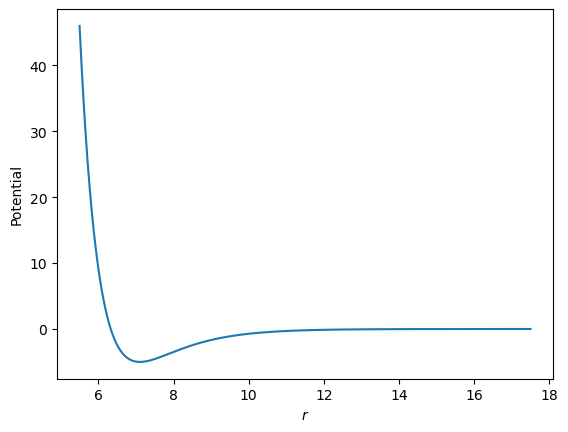

In [6]:
rs = np.arange(5.5, 17.5 + 0.002, 0.002)
Vs = morse_potential(rs)

plt.xlabel("$r$")
plt.ylabel("Potential")
plt.plot(rs, Vs)

### Plots of $A_{l}$, $B_{l}$, and $\delta_{l}$ as a function of $l$

I am making these plots with a constant $E=0.0001$ and values of $l$ from 0 to 50. As expected, when I make these plots, the following behaviour is obeyed:

- $A_{l}$ goes to 1 as $l$ becomes large
- $B_{l}$ goes to 0 as $l$ becomes large
- $\delta_{l}$ goes to 0 as $l$ becomes large
- $\delta_{l}$ is positive everywhere (we are dealing with an attractive potential)

In [7]:
ls = np.arange(0, 51)
As = []
Bs = []
deltas = []

for l in ls:
    A, B, delta = calculate_delta(0.0001, morse_potential, 5.5, 17.5, 0.002, l)
    As.append(A)
    Bs.append(B)
    deltas.append(delta)

#### $A_{l}$ vs. $l$

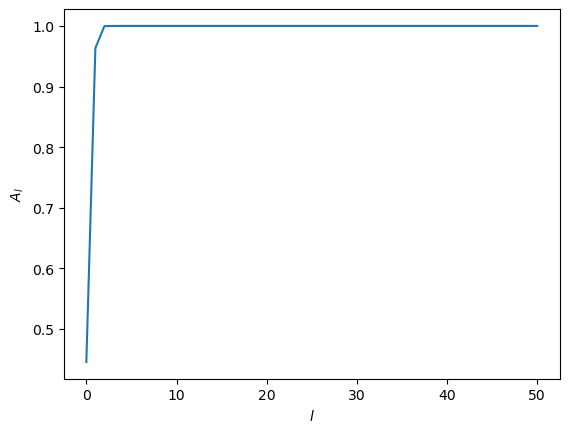

In [8]:
plt.xlabel("$l$")
plt.ylabel("$A_{l}$")
plt.plot(ls, As)

#### $B_{l}$ vs. $l$

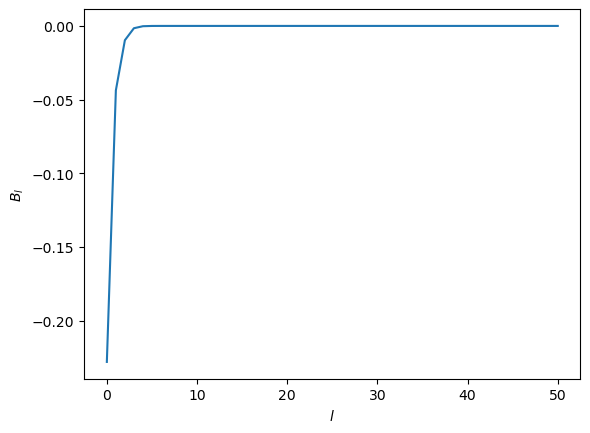

In [9]:
plt.xlabel("$l$")
plt.ylabel("$B_{l}$")
plt.plot(ls, Bs)

#### $\delta_{l}$ vs. $l$

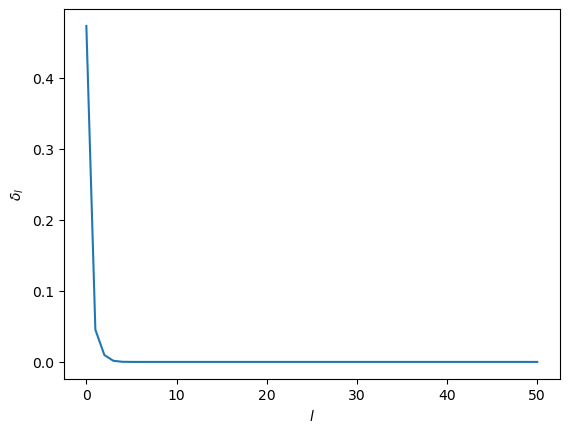

In [10]:
plt.xlabel("$l$")
plt.ylabel("$\delta_{l}$")
plt.plot(ls, deltas)

### Plots of $A_{l}$, $B_{l}$, and $\delta_{l}$ as a function of $E$

I am making these plots with a constant $l=2$ and values of $E$ over the range of $1\times 10^{-10}$ to $1\times 10^{-3}$. The most telling sign that things are working properly is that $\delta_{l}$ is positive over the range of energies that I am plotting over. This makes sense, considering we are working with an attractive potential. The behaviour of $A_{l}$ and $B_{l}$ as $E$ changes is a little less intuitive to me, but the fact that they are opposite in sign everywhere is imperative to maintain $\delta>0$, because $\delta=\tan ^{-1}(\frac{-B}{A})$. 

**Aside:** Note the negative sign in the equation for $\delta_{l}$ in terms of $A_{l}$ and $B_{l}$, which was missed in Millard Alexander's notes on this topic. We defined a separate quantity related to the scattering matrix, $S$, which, in terms of $A_{l}$ and $B_{l}$, is $S = \frac{A - iB}{A + iB}$. It can be shown that $S = e^{2i\delta}$, but if one misses the negative sign in $\delta=\tan ^{-1}(\frac{-B}{A})$, this relationship will not hold ($S$ derived in terms of $A_{l}$ and $B_{l}$ will be the complex conjugate of $S$ derived from $\delta_{l}$).

In [11]:
energies = np.logspace(-10, -3, 100)
As_constant_l = []
Bs_constant_l = []
deltas_constant_l = []

for E in energies:
    A, B, delta = calculate_delta(E, morse_potential, 5.5, 17.5, 0.002, 2)
    As_constant_l.append(A)
    Bs_constant_l.append(B)
    deltas_constant_l.append(delta)

#### $A_{l}$ vs. $E$

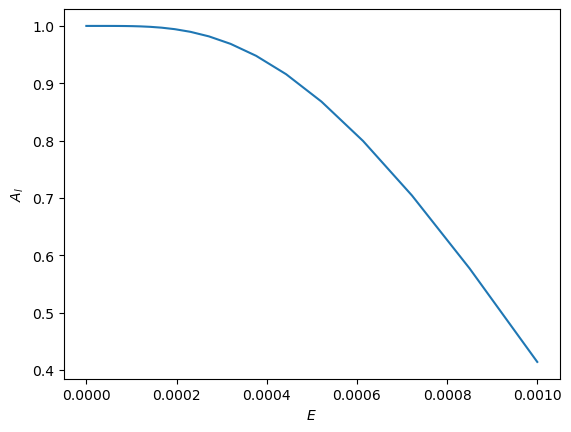

In [12]:
plt.xlabel("$E$")
plt.ylabel("$A_{l}$")
plt.plot(energies, As_constant_l)

$B_{l}$ vs. $E$

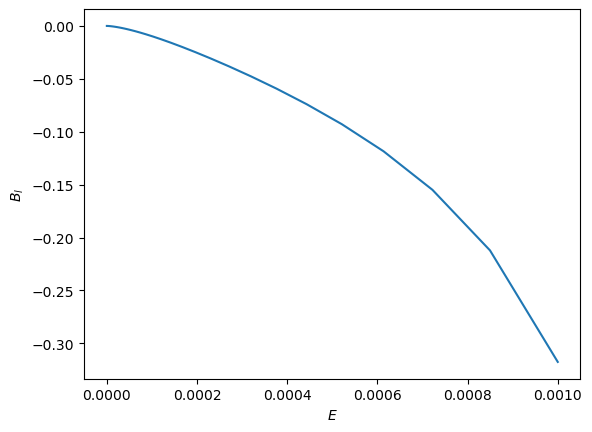

In [13]:
plt.xlabel("$E$")
plt.ylabel("$B_{l}$")
plt.plot(energies, Bs_constant_l)

#### $\delta_{l}$ vs. $E$

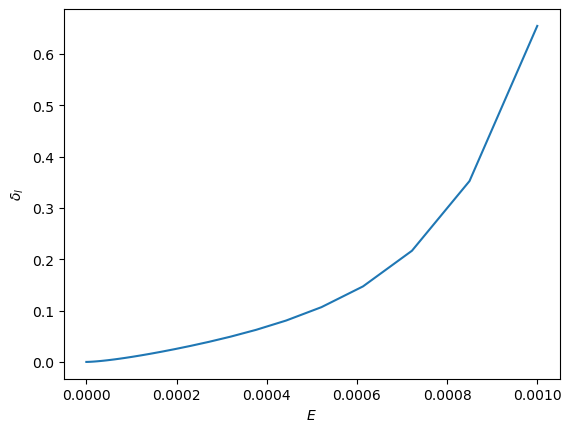

In [14]:
plt.xlabel("$E$")
plt.ylabel("$\delta_{l}$")
plt.plot(energies, deltas_constant_l)

## Shallow Potential Plots

In [15]:
mu = 19.974
re = 7.1053
alpha = 0.89305
De = 4.456e-4
h_bar = 1

i = 1j

To achieve a "shallow" potential, I will set $D_{e} = 4.456\times 10^{-4}$. Here is what that Morse potential looks like (note the much smaller scale on the $y$-axis compared to the other potential we dealt with):

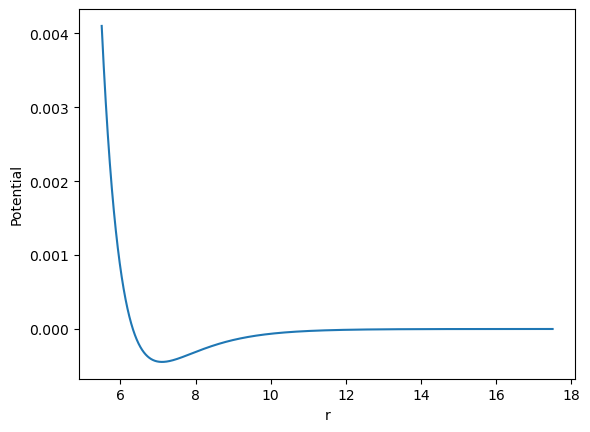

In [16]:
rs = np.arange(5.5, 17.5 + 0.002, 0.002)
Vs = morse_potential(rs)

plt.xlabel("r")
plt.ylabel("Potential")
plt.plot(rs, Vs)

### Plots of $A_{l}$, $B_{l}$, and $\delta_{l}$ as a function of $l$

Once again, I am making these plots with a constant $E=0.0001$ and values of $l$ from 0 to 50. Moving to a shallower potential, the general behaviours of $A_{l}$, $B_{l}$, and $\delta_{l}$ are more or less retained:

- $A_{l}$ goes to 1 as $l$ becomes large
- $B_{l}$ goes to 0 as $l$ becomes large
- $\delta_{l}$ goes to 0 as $l$ becomes large

However, we should take note of the fact that the values of $B_{l}$ and $\delta_{l}$ are extremely small across the board (on the order of $10^{-11}$). In class, we discussed that, as $l$ becomes large, the potential between the two Ar atoms becomes shallower. We already know from when we dealt with the deeper Morse potential that, "$B_{l}$ and $\delta_{l}$ go to 0 as $l$ becomes large." But, we could also rephrase this as, "$B_{l}$ and $\delta_{l}$ go to 0 as the potential between the atoms becomes shallower," because we know that larger values of $l$ yield a shallower potential. When we work with a very shallow potential as we are doing here, I rationalize this almost as offsetting our values of $l$ to some larger values preemptively. Thus, it makes sense that the values of $B_{l}$ and $\delta_{l}$ are effectively zero over the entire range of $l$s that we are experimenting with - the shallow potential necessitates that they be very small.

In [17]:
ls = np.arange(0, 51)
As = []
Bs = []
deltas = []

for l in ls:
    A, B, delta = calculate_delta(0.0001, morse_potential, 5.5, 17.5, 0.002, l)
    As.append(A)
    Bs.append(B)
    deltas.append(delta)

#### $A_{l}$ vs. $l$

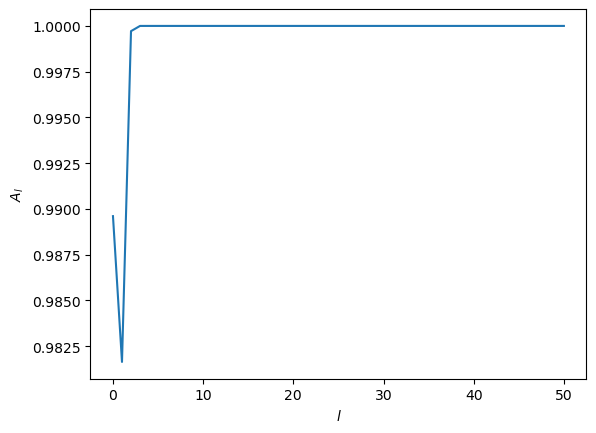

In [18]:
plt.xlabel("$l$")
plt.ylabel("$A_{l}$")
plt.plot(ls, As)

#### $B_{l}$ vs. $l$

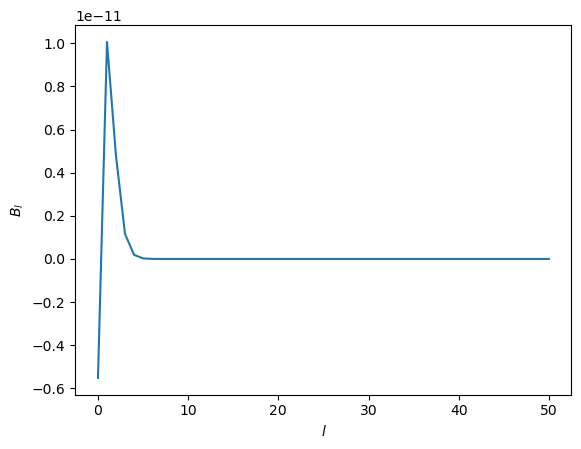

In [19]:
plt.xlabel("$l$")
plt.ylabel("$B_{l}$")
plt.plot(ls, Bs)

#### $\delta_{l}$ vs. $l$

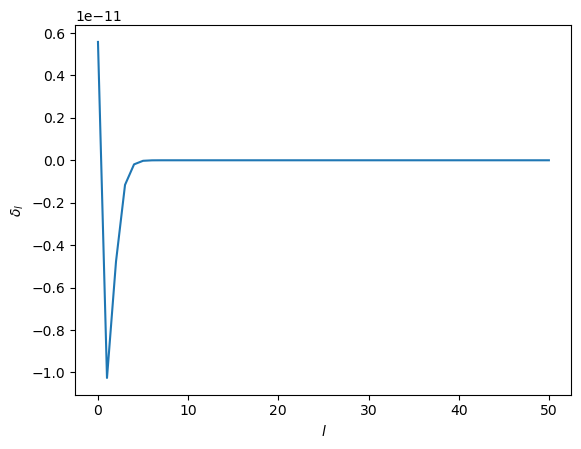

In [20]:
plt.xlabel("$l$")
plt.ylabel("$\delta_{l}$")
plt.plot(ls, deltas)

### Plots of $A_{l}$, $B_{l}$, and $\delta_{l}$ as a function of $E$

As before, these plots have been made with a constant $l=2$ and values of $E$ over the range of $1\times 10^{-10}$ to $1\times 10^{-3}$. 

Comparing the plot of $A_{l}$ vs. $E$ with the shallower potential against the plot with the deeper potential, we can see that they are decently similar. Both start around $A=1$ and then demonstrate what resembles some kind of  sinusoidal decrease as $E$ increases. In the case of the shallower potential, it seems like this decrease in $A_{l}$ with increasing $E$ is made more rapid. My guess is that, in the case of the deeper potential, if I plotted $A_{l}$ against larger values of energy than I did above (e.g., up to $1\times 10^{-2}$ rather than stopping at $1\times 10^{-3}$), I would see further sinusoidal decrease as is demonstrated in the plot from the shallower potential.

The plots of $B_{l}$ vs. $E$ and $\delta_{l}$ vs. $E$ are qualitatively different than what was seen with the deeper potential. However, for reasons discussed above, when working with this shallower potential, $B_{l}$ and $\delta_{l}$ are likely to be very small. This is seen to be the case here, wherein the $y$-axis has a very small scale for these plots. The "jolts" in these two plots may be artifacts of the numerical methods being implemented. If this is true, I wouldn't be very concerned about the qualitative aspects of these plots, and would consider $B_{l}$ and $\delta_{l}$ to be zero over all values of $E$. Otherwise, these jolts may be related to minimum of the Morse potential. You'll notice that things get a bit bumpy around $E=4\times 10^{-4}$, which coincides pretty well with the bottom of our well that sits at $E=4.456\times 10^{-4}$.

In [21]:
energies = np.logspace(-10, -3, 100)
As_constant_l = []
Bs_constant_l = []
deltas_constant_l = []

for E in energies:
    A, B, delta = calculate_delta(E, morse_potential, 5.5, 17.5, 0.002, 2)
    As_constant_l.append(A)
    Bs_constant_l.append(B)
    deltas_constant_l.append(delta)

#### $A_{l}$ vs. $E$

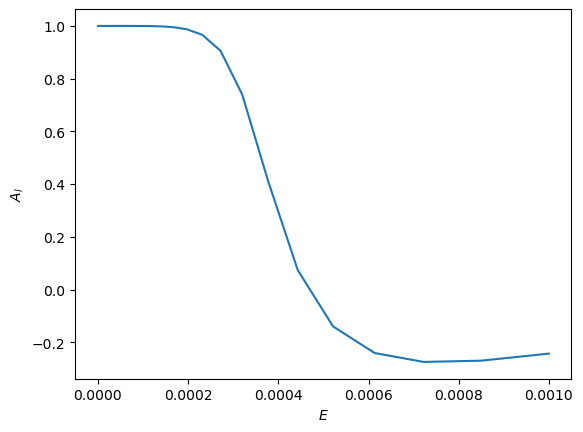

In [22]:
plt.xlabel("$E$")
plt.ylabel("$A_{l}$")
plt.plot(energies, As_constant_l)

#### $B_{l}$ vs. $E$

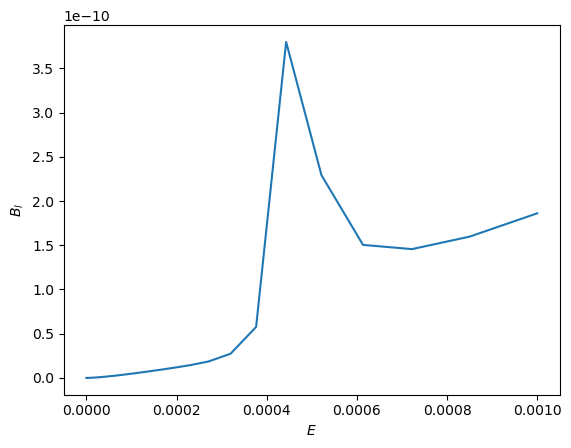

In [23]:
plt.xlabel("$E$")
plt.ylabel("$B_{l}$")
plt.plot(energies, Bs_constant_l)

#### $\delta_{l}$ vs. $E$

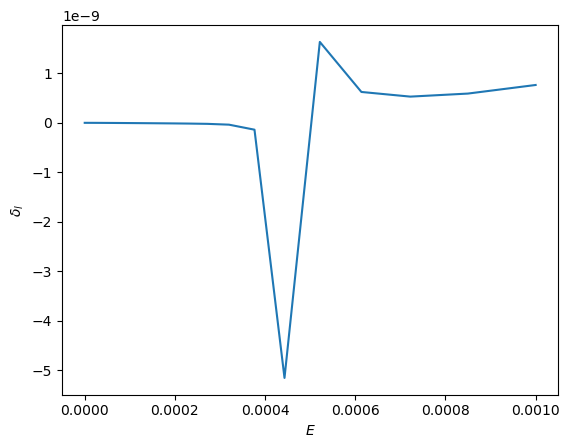

In [24]:
plt.xlabel("$E$")
plt.ylabel("$\delta_{l}$")
plt.plot(energies, deltas_constant_l)